# Nome: Gustavo Henrique Maia Dias

# Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
import time

# Exercicio 1

A representação de uma determinada mensagem digital ternária, isto é formada por três bits, forma um cubo cujos vértices correspondem a mesma representação digital. Supondo que ao transmitirmos esta mensagem a mesma possa ser contaminada por ruído formado em torno de cada vértice uma nuvem esférica de valores aleatórios com raio máximo é 0.1. Formule este problema como um problema de classificação de padrões e treine uma rede Perceptron de Rosenblatt (Perceptron de camada única) para atuar como classificador/decodificador. Para solução do problema defina antes um conjunto de treinamento e um conjunto de validação.

   Dica: O problema pode ser formulado como um problema de classificação de 8 padrões diferentes, sendo que cada padrão representa um vértice do cubo.
   
   - Padrão 1: `x = {0,0,0}` com vetor resposta `d = {1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0}`
   - Padrão 2: `x = {0,0,1}` com vetor resposta `d = {-1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0}`
   - Padrão 3: `x = {0,1,0}` com vetor resposta `d = {-1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0}`
   - Padrão 4: `x = {0,1,1}` com vetor resposta `d = {-1.0, -1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0}`
   - Padrão 5: `x = {1,0,0}` com vetor resposta `d = {-1.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0, -1.0}`
   - Padrão 6: `x = {1,0,1}` com vetor resposta `d = {-1.0, -1.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0}`
   - Padrão 7: `x = {1,1,0}` com vetor resposta `d = {-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, -1.0}`
   - Padrão 8: `x = {1,1,1}` com vetor resposta `d = {-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0}`


#### 1. Definições e Funções Auxiliares

In [2]:
def funcao_ativacao(x, alpha=0.01):
    return tf.maximum(alpha * x, x)

def passo_treinamento_perceptron_simples(entradas, rotulos, peso):
    """
    Etapa de treinamento para um único perceptron.
    
    Args:
        entradas (tf.Tensor): Tensor de entradas para o perceptron.
        rotulos (tf.Tensor): Tensor com os rótulos reais/verdadeiros.
        peso (tf.Variable): Peso do perceptron a ser ajustado.
        
    Returns:
        tf.Tensor: Valor da perda (MSE) após a atualização dos pesos.
    """
    
    # Multiplica as entradas pelos pesos para obter os logits (antes da ativação).
    logits = tf.matmul(entradas, peso)
    
    # Passa os logits pela função de ativação.
    previsoes = funcao_ativacao(logits)

    # Itera sobre todas as entradas.
    for i in range(entradas.shape[0]):
        # Se a previsão não corresponder ao rótulo real
        if previsoes[i, 0] != rotulos[i, 0]:
            # Calcula a atualização do peso. O vetor de entrada é redimensionado e multiplicado
            # pela taxa de aprendizado e pelo rótulo real.
            atualizacao = TAXA_APRENDIZADO * tf.reshape(entradas[i, :], shape=(3, 1)) * rotulos[i, 0]
            
            # Atualiza o peso com a correção calculada.
            peso.assign_add(atualizacao)

    # Calcula a perda (erro quadrático médio) entre as previsões e os rótulos reais.
    perda = tf.reduce_mean(tf.losses.mean_squared_error(rotulos, previsoes))
    
    return perda

def avaliar(entradas, pesos):
    """
    Avalia a entrada usando os perceptrons treinados.
    
    Args:
        entradas (tf.Tensor): Tensor contendo as entradas a serem avaliadas.
        pesos (list): Lista de tensores de peso para cada perceptron.
        
    Returns:
        tf.Tensor: One-hot encoded tensor representando a classe prevista.
    """

    # Lista para armazenar os logits de cada perceptron.
    lista_logits = []
    
    # Itera sobre todos os 8 perceptrons.
    for i in range(8):
        # Calcula o logit para o perceptron atual usando a entrada e seu respectivo peso.
        logits = tf.matmul(entradas, pesos[i])
        # Adiciona os logits calculados à lista.
        lista_logits.append(logits)

    # Combina os logits de todos os perceptrons em um único tensor.
    logits_combinados = tf.concat(lista_logits, axis=1)
    
    # Encontra os índices dos logits máximos ao longo do eixo 1 (eixo das colunas).
    # Essencialmente, determina qual perceptron deu a maior confiança/saída para cada entrada.
    max_indices = tf.argmax(logits_combinados, axis=1, output_type=tf.int32)
    
    # Converte os índices máximos em uma representação one-hot.
    # Por exemplo, se max_indices for [2, 3], a saída será:
    # [
    #     [0, 0, 1, 0, 0, 0, 0, 0],
    #     [0, 0, 0, 1, 0, 0, 0, 0]
    # ]
    # Esta representação ajuda a identificar facilmente qual perceptron "venceu" para cada entrada.
    max_one_hot = tf.one_hot(max_indices, depth=8, on_value=1.0, off_value=-1.0, dtype=tf.float32)
    
    return max_one_hot

#### 2. Preparação dos Dados


In [3]:
import numpy as np
import tensorflow as tf

# Conjunto de dados original
X_treino = np.array([
    [0, 0, 0], [0, 0, 1], [0, 1, 0], [0, 1, 1],
    [1, 0, 0], [1, 0, 1], [1, 1, 0], [1, 1, 1]
], dtype=np.float32)

y_treino = np.array([
    [1, -1, -1, -1, -1, -1, -1, -1],
    [-1, 1, -1, -1, -1, -1, -1, -1],
    [-1, -1, 1, -1, -1, -1, -1, -1],
    [-1, -1, -1, 1, -1, -1, -1, -1],
    [-1, -1, -1, -1, 1, -1, -1, -1],
    [-1, -1, -1, -1, -1, 1, -1, -1],
    [-1, -1, -1, -1, -1, -1, 1, -1],
    [-1, -1, -1, -1, -1, -1, -1, 1]
], dtype=np.float32)

# Número de vezes para replicar os dados
num_replicacoes = 5000

# Desvios padrões de ruído para cada item em X_treino
desvios_padroes = np.array([
    0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4
])

# Replicar os dados
X_aumentado = np.tile(X_treino, (num_replicacoes, 1))
y_aumentado = np.tile(y_treino, (num_replicacoes, 1))

# Injetar ruído
for i in range(8):  # Para cada linha em X_treino
    start_idx = i * num_replicacoes
    end_idx = (i + 1) * num_replicacoes
    X_aumentado[start_idx:end_idx] += np.random.normal(0, desvios_padroes[i], (num_replicacoes, 3))

X_treino_tf = tf.convert_to_tensor(X_aumentado)
y_treino_tf = tf.convert_to_tensor(y_aumentado)

2023-09-21 16:02:31.744685: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2023-09-21 16:02:31.744700: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-09-21 16:02:31.744705: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-09-21 16:02:31.744735: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-09-21 16:02:31.744749: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


#### 3. Configuração do Modelo

In [4]:
# Define a taxa de aprendizado para o treinamento.
TAXA_APRENDIZADO = 0.1

# Inicializa uma lista de tensores em que cada um representa os pesos de um perceptron individual.
# Eles são inicializados com valores aleatórios seguindo uma distribuição normal.
pesos = [tf.Variable(tf.random.normal([3, 1], dtype=tf.float32)) for _ in range(8)]


#### 4. Treinamento

In [5]:
# Define o número total de épocas (iterações completas sobre todo o conjunto de treinamento).
epocas = 150

# Record the start time
start_time = time.time()

# Inicia o loop de treinamento para o número especificado de épocas.
for epoca in range(epocas):
    
    # Itera sobre cada uma das 8 classes (ou perceptrons) para treinamento.
    for i in range(8):
        
        # Isola os rótulos da classe atual (i).
        rotulos_classe_unica = y_treino[:, i:i+1]
        
        # A perda (erro) resultante deste treinamento é armazenada.
        perda = passo_treinamento_perceptron_simples(X_treino, rotulos_classe_unica, pesos[i])

    # Após treinar todos os perceptrons, avalia a acurácia do modelo no conjunto de treinamento.
    acuracia = tf.reduce_mean(tf.cast(tf.equal(avaliar(X_treino, pesos), y_treino), tf.float32))
    
    # A cada 10 épocas, imprime a perda e a acurácia.
    if epoca % 10 == 0:
        print(f"Época {epoca}, Perda: {perda:.4f}, Acurácia: {acuracia:.4f}")

# Record the end time
end_time = time.time()

# Calculate the time taken
time_taken = end_time - start_time

print(f"\nTempo total de execução: {time_taken:.2f} segundos.")

Época 0, Perda: 1.4948, Acurácia: 0.8750
Época 10, Perda: 0.9684, Acurácia: 0.9688
Época 20, Perda: 0.9423, Acurácia: 1.0000
Época 30, Perda: 0.9185, Acurácia: 1.0000
Época 40, Perda: 0.8972, Acurácia: 1.0000
Época 50, Perda: 0.8782, Acurácia: 1.0000
Época 60, Perda: 0.8617, Acurácia: 1.0000
Época 70, Perda: 0.8475, Acurácia: 1.0000
Época 80, Perda: 0.8358, Acurácia: 1.0000
Época 90, Perda: 0.8264, Acurácia: 1.0000
Época 100, Perda: 0.8195, Acurácia: 1.0000
Época 110, Perda: 0.8149, Acurácia: 1.0000
Época 120, Perda: 0.8127, Acurácia: 1.0000
Época 130, Perda: 0.8130, Acurácia: 1.0000
Época 140, Perda: 0.8156, Acurácia: 1.0000

Tempo total de execução: 20.28 segundos.


#### 5. Avaliação

In [6]:
# Usa a função 'avaliar' para obter as previsões do modelo para todo o conjunto de treinamento (X_treino).
previsoes = avaliar(X_treino, pesos)

# Compara essas previsões aos rótulos verdadeiros (y_treino) gerando uma matriz booleana de acertos/erros.
comparacao = tf.equal(previsoes, y_treino)

# Converte a matriz booleana para valores em ponto flutuante (1.0 para True, 0.0 para False).
comparacao_float = tf.cast(comparacao, tf.float32)

# Calcula a média desses valores, resultando na acurácia.
acuracia = tf.reduce_mean(comparacao_float)

# Imprime a acurácia calculada.
print(f"Acurácia de Treinamento: {acuracia:.4f}")

# Itera sobre cada amostra do conjunto de treinamento.
for i, tensor_entrada in enumerate(X_treino):
    # Para cada amostra, imprime a entrada e o rótulo previsto correspondente.
    print(f"Entrada: {tensor_entrada}, Rótulos previstos: {avaliar(tensor_entrada[tf.newaxis, :], pesos).numpy()}")


Acurácia de Treinamento: 1.0000
Entrada: [0. 0. 0.], Rótulos previstos: [[ 1. -1. -1. -1. -1. -1. -1. -1.]]
Entrada: [0. 0. 1.], Rótulos previstos: [[-1.  1. -1. -1. -1. -1. -1. -1.]]
Entrada: [0. 1. 0.], Rótulos previstos: [[-1. -1.  1. -1. -1. -1. -1. -1.]]
Entrada: [0. 1. 1.], Rótulos previstos: [[-1. -1. -1.  1. -1. -1. -1. -1.]]
Entrada: [1. 0. 0.], Rótulos previstos: [[-1. -1. -1. -1.  1. -1. -1. -1.]]
Entrada: [1. 0. 1.], Rótulos previstos: [[-1. -1. -1. -1. -1.  1. -1. -1.]]
Entrada: [1. 1. 0.], Rótulos previstos: [[-1. -1. -1. -1. -1. -1.  1. -1.]]
Entrada: [1. 1. 1.], Rótulos previstos: [[-1. -1. -1. -1. -1. -1. -1.  1.]]


# Exercicio 2

Implemente uma rede perceptron de múltiplas camadas e utilize-a para aproximar as funções abaixo. Em seguida, compare os resultados com as curvas exatas. No caso das letras (b) e (c), apresente também a curva do erro médio de treinamento com relação ao número de épocas e a curva do erro médio com o conjunto de validação.


### a) A função lógica XOR

#### 1. Preparação dos Dados

In [7]:
# Função lógica XOR
X_xor = np.array([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=np.float32)
y_xor = np.array([[0], [1], [1], [0]], dtype=np.float32)

#### 2. Configuração da Rede Neural

In [8]:
# Define a arquitetura da rede neural
tamanho_entrada = 2   # Define o tamanho da camada de entrada, que possui 2 neurônios (ou 2 características de entrada)
tamanho_oculto = 8   # Define o tamanho da camada oculta, que possui 8 neurônios
tamanho_saida = 1    # Define o tamanho da camada de saída, que possui 1 neurônio (para uma saída única)

# W1 representa os pesos que conectam a camada de entrada à camada oculta.
W1 = tf.Variable(tf.random.truncated_normal([tamanho_entrada, tamanho_oculto], mean=0, stddev=0.1))

# b1 é o vetor de vieses para a camada oculta. Cada neurônio na camada oculta tem um viés.
b1 = tf.Variable(tf.zeros([tamanho_oculto]))

# W2 representa os pesos que conectam a camada oculta à camada de saída.
W2 = tf.Variable(tf.random.truncated_normal([tamanho_oculto, tamanho_saida], mean=0, stddev=0.1))

# b2 é o viés para o neurônio na camada de saída.
b2 = tf.Variable(tf.zeros([tamanho_saida]))

# Parâmetros de aprendizado
taxa_aprendizado = 0.2
num_epocas = 2001

#### 3. Funções da Rede Neural

In [9]:
# Função de propagação para a predição do XOR
def propagacao(x):
    # Ele é calculado multiplicando a entrada x pelos pesos W1 e adicionando o viés b1.
    z1 = tf.matmul(x, W1) + b1
    
    # a1 é a saída da camada oculta após aplicar a função de ativação tanh.
    a1 = tf.nn.tanh(z1)
    
    # É calculado multiplicando a saída da camada oculta a1 pelos pesos W2 e adicionando o viés b2.
    z2 = tf.matmul(a1, W2) + b2
    
    # A saída final da rede é calculada aplicando a função de ativação sigmoide ao z2.
    return tf.nn.sigmoid(z2)


#### 4. Laço de Treinamento

In [10]:
# Record the start time
start_time = time.time()

# Lista para armazenar os valores de perda e acurácia durante o treinamento
perdas = []
acuracias = []

for epoca in range(num_epocas):
    with tf.GradientTape() as tape:
        # Faz a propagação para a frente, passando os dados de entrada através da rede
        y_pred = propagacao(X_xor)
        # Calcula a perda usando a entropia cruzada binária entre os rótulos reais e as previsões
        perda = tf.reduce_mean(tf.keras.losses.binary_crossentropy(y_xor, y_pred))
        # Calcula a acurácia comparando as previsões arredondadas com os rótulos reais
        acuracia = np.mean(np.round(y_pred.numpy()) == y_xor)

        # Calcula os gradientes da perda em relação aos pesos e vieses
        gradientes = tape.gradient(perda, [W1, b1, W2, b2])
        
        # Atualiza os pesos e vieses subtraindo a taxa de aprendizado multiplicada pelo gradiente
        W1.assign_sub(taxa_aprendizado * gradientes[0])
        b1.assign_sub(taxa_aprendizado * gradientes[1])
        W2.assign_sub(taxa_aprendizado * gradientes[2])
        b2.assign_sub(taxa_aprendizado * gradientes[3])

        # A cada 100 épocas, registra a perda e a acurácia e imprime
        if epoca % 100 == 0:
            perdas.append(perda.numpy())
            acuracias.append(acuracia)
            print(f"Época {epoca}: Perda: {perda:.4f}, Acurácia: {acuracia:.4f}")

# Record the end time
end_time = time.time()

# Calculate the time taken
time_taken = end_time - start_time

print(f"\nTempo total de execução: {time_taken:.2f} segundos.")


Época 0: Perda: 0.6932, Acurácia: 0.7500
Época 100: Perda: 0.6932, Acurácia: 0.5000
Época 200: Perda: 0.6932, Acurácia: 0.5000
Época 300: Perda: 0.6931, Acurácia: 0.5000
Época 400: Perda: 0.6931, Acurácia: 0.5000
Época 500: Perda: 0.6931, Acurácia: 0.5000
Época 600: Perda: 0.6930, Acurácia: 0.5000
Época 700: Perda: 0.6929, Acurácia: 0.5000
Época 800: Perda: 0.6927, Acurácia: 0.5000
Época 900: Perda: 0.6920, Acurácia: 0.5000
Época 1000: Perda: 0.6883, Acurácia: 0.7500
Época 1100: Perda: 0.6636, Acurácia: 0.7500
Época 1200: Perda: 0.5612, Acurácia: 0.7500
Época 1300: Perda: 0.3976, Acurácia: 1.0000
Época 1400: Perda: 0.2389, Acurácia: 1.0000
Época 1500: Perda: 0.1409, Acurácia: 1.0000
Época 1600: Perda: 0.0844, Acurácia: 1.0000
Época 1700: Perda: 0.0542, Acurácia: 1.0000
Época 1800: Perda: 0.0377, Acurácia: 1.0000
Época 1900: Perda: 0.0279, Acurácia: 1.0000
Época 2000: Perda: 0.0217, Acurácia: 1.0000

Tempo total de execução: 9.96 segundos.


#### 5. Visualização

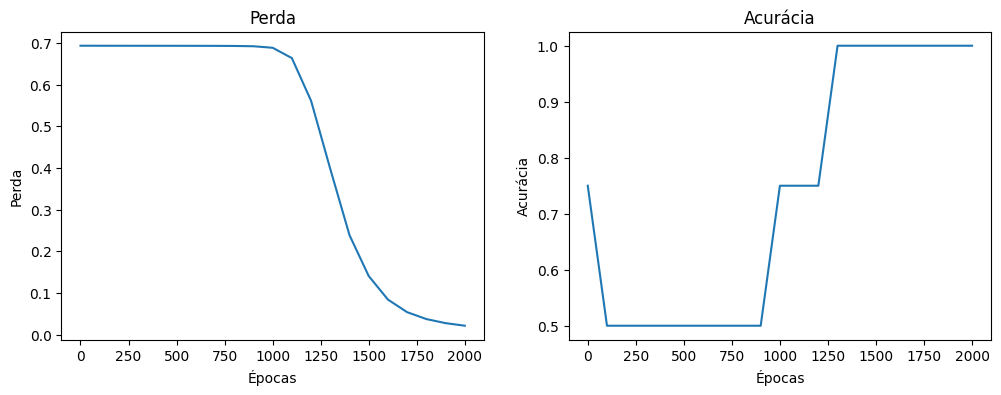

In [11]:
# Plota perda e acurácia
intervalo_epocas = range(0, num_epocas, 100)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(intervalo_epocas, perdas, label='Perda')
plt.title('Perda')
plt.xlabel('Épocas')
plt.ylabel('Perda')

plt.subplot(1, 2, 2)
plt.plot(intervalo_epocas, acuracias, label='Acurácia')
plt.title('Acurácia')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.show()

### b) f(x) = log10(x), onde 1 ≤ x ≤ 10

#### 1. Preparação dos Dados

In [12]:
# Criando um array linearmente espaçado de 1 a 10 com 1000 pontos e assegurando que os valores sejam do tipo float32.
X_log = np.linspace(1, 10, 1000)[:, np.newaxis].astype(np.float32)

# Calculando o logaritmo na base 10 de cada ponto em X_log e garantindo o tipo float32.
y_log = np.log10(X_log).astype(np.float32)

# Determinando o índice para dividir o conjunto de dados em 80% de treinamento e 20% de validação.
split_idx = int(0.8 * len(X_log))

# Dividindo os conjuntos de dados X_log e y_log em treinamento e validação.
X_train_log, X_val_log = X_log[:split_idx], X_log[split_idx:]
y_train_log, y_val_log = y_log[:split_idx], y_log[split_idx:]

### 2. Configuração da Rede Neural

In [13]:
# Determina o tamanho da entrada com base na primeira dimensão do conjunto de treinamento
input_size_log = X_train_log.shape[1]

# Define o tamanho das camadas ocultas da rede neural
hidden_size1_log = 100  # Primeira camada oculta tem 100 neurônios
hidden_size2_log = 100  # Segunda camada oculta tem 100 neurônios
hidden_size3_log = 50   # Terceira camada oculta tem 50 neurônios

# O tamanho da camada de saída é definido como 1
output_size_log = 1

# Inicialização dos pesos e vieses para a rede neural:

# W1_log e b1_log são os pesos e vieses da primeira camada oculta, respectivamente
W1_log = tf.Variable(tf.random.normal([input_size_log, hidden_size1_log], mean=0, stddev=0.1, dtype=tf.float32))
b1_log = tf.Variable(tf.zeros([hidden_size1_log], dtype=tf.float32))

# W2_log e b2_log são os pesos e vieses da segunda camada oculta, respectivamente
W2_log = tf.Variable(tf.random.normal([hidden_size1_log, hidden_size2_log], mean=0, stddev=0.1, dtype=tf.float32))
b2_log = tf.Variable(tf.zeros([hidden_size2_log], dtype=tf.float32))

# W3_log e b3_log são os pesos e vieses da terceira camada oculta, respectivamente
W3_log = tf.Variable(tf.random.normal([hidden_size2_log, hidden_size3_log], mean=0, stddev=0.1, dtype=tf.float32))
b3_log = tf.Variable(tf.zeros([hidden_size3_log], dtype=tf.float32))

# W4_log e b4_log são os pesos e vieses da camada de saída, respectivamente
W4_log = tf.Variable(tf.random.normal([hidden_size3_log, output_size_log], mean=0, stddev=0.1, dtype=tf.float32))
b4_log = tf.Variable(tf.zeros([output_size_log], dtype=tf.float32))

# Define a taxa de aprendizado da rede neural
lr_log = 0.005

# Define o número de épocas para o treinamento da rede neural
num_epochs_log = 2000

#### 3. Função de Predição

In [14]:
# Define a função forward para a rede neural que modela log10(x)
def forward_log(x):
    # Primeira camada:
    # Calcula a pré-ativação (z1_log) multiplicando a entrada por W1_log e adicionando o viés b1_log
    z1_log = tf.matmul(x, W1_log) + b1_log
    # Aplica a função de ativação tangente hiperbólica para obter a ativação da primeira camada oculta (a1_log)
    a1_log = tf.nn.tanh(z1_log)

    # Segunda camada:
    # Calcula a pré-ativação (z2_log) multiplicando a1_log por W2_log e adicionando o viés b2_log
    z2_log = tf.matmul(a1_log, W2_log) + b2_log
    # Aplica a função de ativação tangente hiperbólica para obter a ativação da segunda camada oculta (a2_log)
    a2_log = tf.nn.tanh(z2_log)

    # Terceira camada:
    # Calcula a pré-ativação (z3_log) multiplicando a2_log por W3_log e adicionando o viés b3_log
    z3_log = tf.matmul(a2_log, W3_log) + b3_log
    # Aplica a função de ativação tangente hiperbólica para obter a ativação da terceira camada oculta (a3_log)
    a3_log = tf.nn.tanh(z3_log)

    # Camada de saída:
    # Calcula a pré-ativação (z4_log) multiplicando a3_log por W4_log e adicionando o viés b4_log
    # Como é a camada de saída e estamos tentando prever um valor contínuo, não há função de ativação aplicada aqui
    z4_log = tf.matmul(a3_log, W4_log) + b4_log

    return z4_log

### 4. Treinamento

In [15]:
# Record the start time
start_time = time.time()

# Define a função para calcular o Erro Absoluto Médio (EAM)
def erro_absoluto_medio(verdadeiro, previsto):
    return tf.reduce_mean(tf.abs(verdadeiro - previsto))

# Listas para armazenar a perda (erro) durante o treinamento e validação
perdas_treino = []
perdas_validacao = []

# Loop de treinamento por um número predefinido de épocas
for epoca in range(num_epochs_log):
    # Usa o tf.GradientTape para monitorar operações e computar gradientes
    with tf.GradientTape() as tape:
        # Faz a propagação para a frente, passando os dados de treinamento pela rede
        y_pred_treino = forward_log(X_train_log)
        # Calcula a perda usando o erro quadrático médio entre os rótulos reais e as previsões
        perda_treino = tf.reduce_mean(tf.square(y_pred_treino - y_train_log))

        # Calcula os gradientes da perda em relação aos pesos e vieses
        gradientes = tape.gradient(perda_treino, [W1_log, b1_log, W2_log, b2_log, W3_log, b3_log, W4_log, b4_log])
        
        # Atualiza os pesos e vieses usando a técnica de descida do gradiente
        W1_log.assign_sub(lr_log * gradientes[0])
        b1_log.assign_sub(lr_log * gradientes[1])
        W2_log.assign_sub(lr_log * gradientes[2])
        b2_log.assign_sub(lr_log * gradientes[3])
        W3_log.assign_sub(lr_log * gradientes[4])
        b3_log.assign_sub(lr_log * gradientes[5])
        W4_log.assign_sub(lr_log * gradientes[6])
        b4_log.assign_sub(lr_log * gradientes[7])

        # Calcula o EAM para o conjunto de treinamento
        eam_treino = erro_absoluto_medio(y_train_log, y_pred_treino).numpy()
        # Adiciona a perda atual à lista de perdas de treinamento
        perdas_treino.append(perda_treino.numpy())

        # Faz predições usando o conjunto de validação
        y_pred_validacao = forward_log(X_val_log)
        # Calcula a perda para o conjunto de validação
        perda_validacao = tf.reduce_mean(tf.square(y_pred_validacao - y_val_log))
        # Calcula o EAM para o conjunto de validação
        eam_validacao = erro_absoluto_medio(y_val_log, y_pred_validacao).numpy()
        # Adiciona a perda de validação à lista correspondente
        perdas_validacao.append(perda_validacao.numpy())

        # Imprime as métricas a cada 100 épocas
        if epoca % 100 == 0:
            print(f"Época {epoca}/{num_epochs_log}: Perda de Treinamento: {perda_treino:.4f}, EAM de Treinamento: {eam_treino:.4f}, Perda de Validação: {perda_validacao:.4f}, EAM de Validação: {eam_validacao:.4f}")

# Imprime as métricas finais após o término do treinamento
print(f"\nResultados Finais para log10(x):")
print(f"Perda de Treinamento: {perdas_treino[-1]:.4f}, EAM de Treinamento: {eam_treino:.4f}")
print(f"Perda de Validação: {perdas_validacao[-1]:.4f}, EAM de Validação: {eam_validacao:.4f}")

# Record the end time
end_time = time.time()

# Calculate the time taken
time_taken = end_time - start_time

print(f"\nTempo total de execução: {time_taken:.2f} segundos.")

Época 0/2000: Perda de Treinamento: 0.2737, EAM de Treinamento: 0.4808, Perda de Validação: 0.4948, EAM de Validação: 0.7030
Época 100/2000: Perda de Treinamento: 0.0031, EAM de Treinamento: 0.0384, Perda de Validação: 0.0055, EAM de Validação: 0.0731
Época 200/2000: Perda de Treinamento: 0.0019, EAM de Treinamento: 0.0275, Perda de Validação: 0.0029, EAM de Validação: 0.0528
Época 300/2000: Perda de Treinamento: 0.0013, EAM de Treinamento: 0.0197, Perda de Validação: 0.0015, EAM de Validação: 0.0379
Época 400/2000: Perda de Treinamento: 0.0009, EAM de Treinamento: 0.0151, Perda de Validação: 0.0008, EAM de Validação: 0.0270
Época 500/2000: Perda de Treinamento: 0.0007, EAM de Treinamento: 0.0126, Perda de Validação: 0.0004, EAM de Validação: 0.0191
Época 600/2000: Perda de Treinamento: 0.0006, EAM de Treinamento: 0.0112, Perda de Validação: 0.0002, EAM de Validação: 0.0135
Época 700/2000: Perda de Treinamento: 0.0005, EAM de Treinamento: 0.0111, Perda de Validação: 0.0001, EAM de Vali

#### 5. Visualização dos Resultados

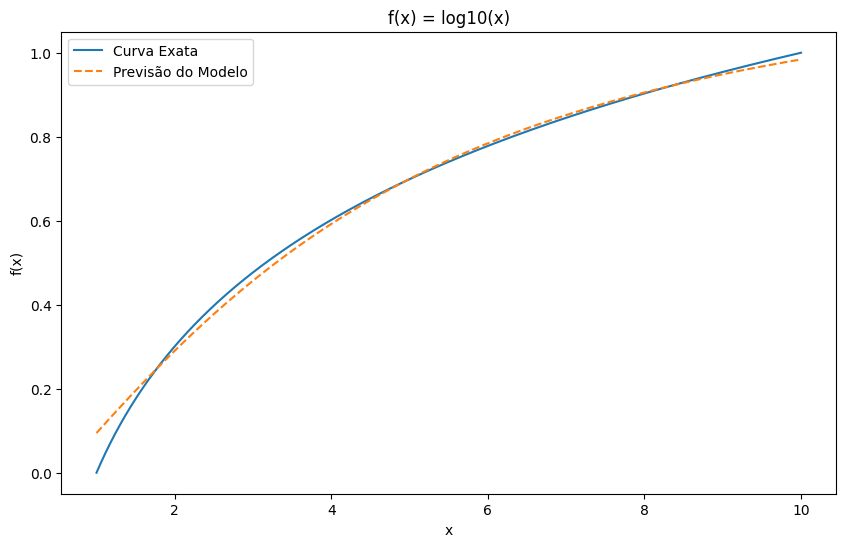

In [16]:
y_pred_log = forward_log(X_log)

plt.figure(figsize=(10, 6))
plt.plot(X_log, y_log, label='Curva Exata')
plt.plot(X_log, y_pred_log, label='Previsão do Modelo', linestyle='--')
plt.title('f(x) = log10(x)')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.show()

### c) f(x) = 10x5+ 5x4+ 2x3– 0.5x2+ 3x + 2, onde 0 ≤ x ≤ 20

#### 1. Definição da Função Polinomial

In [17]:
# Cria um array linearmente espaçado de 0 a 20 com 1000 pontos.
# A função `np.newaxis` é usada para transformar o array 1D em 2D (1000x1).
X_poly = np.linspace(0, 20, 1000)[:, np.newaxis]

# Calcula os valores 'y' usando a equação polinomial fornecida para cada valor em X_poly.
# A equação é um polinômio de grau 5.
y_poly = 10*X_poly**5 + 5*X_poly**4 + 2*X_poly**3 - 0.5*X_poly**2 + 3*X_poly + 2

#### 2. Pré-processamento de Dados

In [18]:
# Cria uma nova matriz com características polinomiais (potências) de X_poly.
# Por exemplo, se X_poly contém valores [a, b], a nova matriz terá [a, a^2, a^3, ..., a^5] para cada linha.
X_poly_caracteristicas = np.hstack([X_poly**i for i in range(1, 6)])

# Calcula a média e o desvio padrão para cada coluna (característica) de X_poly_caracteristicas.
X_poly_media, X_poly_desvio = X_poly_caracteristicas.mean(axis=0), X_poly_caracteristicas.std(axis=0)

# Calcula a média e o desvio padrão para o vetor y_poly.
y_poly_media, y_poly_desvio = y_poly.mean(), y_poly.std()

# Normaliza X_poly_caracteristicas subtraindo a média e dividindo pelo desvio padrão.
X_poly_norm = ((X_poly_caracteristicas - X_poly_media) / X_poly_desvio).astype(np.float32)

# Normaliza y_poly subtraindo a média e dividindo pelo desvio padrão.
y_poly_norm = ((y_poly - y_poly_media) / y_poly_desvio).astype(np.float32)

# Determina o índice que separa 80% dos dados para treinamento.
indice_divisao = int(0.8 * len(X_poly_norm))

# Divide os conjuntos de dados normalizados em conjuntos de treinamento e validação usando o índice calculado.
X_treino_poly, X_valid_poly = X_poly_norm[:indice_divisao], X_poly_norm[indice_divisao:]
y_treino_poly, y_valid_poly = y_poly_norm[:indice_divisao], y_poly_norm[indice_divisao:]

### 3. Definição da Arquitetura da Rede Neural

In [19]:
# Define o tamanho da entrada baseado na forma (ou dimensão) do conjunto de dados normalizado.
tamanho_entrada = X_poly_norm.shape[1]

# Define os tamanhos das camadas ocultas da rede neural.
tamanho_oculto1 = 2500
tamanho_oculto2 = 800
tamanho_oculto3 = 400
tamanho_oculto4 = 200

# Define o tamanho da camada de saída.
tamanho_saida = 1

# Inicializa os pesos e vieses para a primeira camada oculta.
W1 = tf.Variable(tf.random.normal([tamanho_entrada, tamanho_oculto1], mean=0, stddev=0.1))
b1 = tf.Variable(tf.zeros([tamanho_oculto1]))

# Inicializa os pesos e vieses para a segunda camada oculta.
W2 = tf.Variable(tf.random.normal([tamanho_oculto1, tamanho_oculto2], mean=0, stddev=0.1))
b2 = tf.Variable(tf.zeros([tamanho_oculto2]))

# Inicializa os pesos e vieses para a terceira camada oculta.
W3 = tf.Variable(tf.random.normal([tamanho_oculto2, tamanho_oculto3], mean=0, stddev=0.1))
b3 = tf.Variable(tf.zeros([tamanho_oculto3]))

# Inicializa os pesos e vieses para a quarta camada oculta.
W4 = tf.Variable(tf.random.normal([tamanho_oculto3, tamanho_oculto4], mean=0, stddev=0.1))
b4 = tf.Variable(tf.zeros([tamanho_oculto4]))

# Inicializa os pesos e vieses para a camada de saída.
W5 = tf.Variable(tf.random.normal([tamanho_oculto4, tamanho_saida], mean=0, stddev=0.1))
b5 = tf.Variable(tf.zeros([tamanho_saida]))

# Define a função de propagação (ou forward pass) da rede neural.
def propaga(x):
    # Camada oculta 1: Multiplicação matriz-vector, adição de viés e aplicação da função de ativação ReLU.
    z1 = tf.matmul(x, W1) + b1
    a1 = tf.nn.relu(z1)
    
    # Camada oculta 2: Mesma sequência de operações.
    z2 = tf.matmul(a1, W2) + b2
    a2 = tf.nn.relu(z2)
    
    # Camada oculta 3: Mesma sequência de operações.
    z3 = tf.matmul(a2, W3) + b3
    a3 = tf.nn.relu(z3)
    
    # Camada oculta 4: Mesma sequência de operações.
    z4 = tf.matmul(a3, W4) + b4
    a4 = tf.nn.relu(z4)
    
    # Camada de saída: Apenas multiplicação matriz-vector e adição de viés.
    z5 = tf.matmul(a4, W5) + b5
    
    return z5

#### 4. Treinamento da Rede

In [20]:
# Define a taxa de aprendizado que será utilizada na atualização dos pesos e vieses.
taxa_aprendizado = 0.001

# Define o número total de épocas (ciclos completos sobre o conjunto de treinamento).
num_epocas = 500

# Lista para armazenar o valor da função de perda após cada época.
perdas = []

# Função para calcular o Erro Absoluto Médio (MAE).
def erro_absoluto_medio(verdadeiro, previsto):
    return tf.reduce_mean(tf.abs(verdadeiro - previsto))

# Start the timer
start_time = time.time()

for epoca in range(num_epocas):
    with tf.GradientTape() as tape:
        # Realiza a propagação (forward pass) para obter as previsões.
        y_pred = propaga(X_treino_poly)
        
        # Calcula a perda (loss) usando o erro quadrático médio entre a previsão e os valores reais.
        perda = tf.reduce_mean(tf.square(y_pred - y_treino_poly))
    
        # Calcula os gradientes da perda em relação a cada variável (pesos e vieses) usando a tape.
        gradientes = tape.gradient(perda, [W1, b1, W2, b2, W3, b3, W4, b4, W5, b5])
        
        ## Atualização dos pesos e vieses.
        W1.assign_sub(taxa_aprendizado * gradientes[0])
        b1.assign_sub(taxa_aprendizado * gradientes[1])
        W2.assign_sub(taxa_aprendizado * gradientes[2])
        b2.assign_sub(taxa_aprendizado * gradientes[3])
        W3.assign_sub(taxa_aprendizado * gradientes[4])
        b3.assign_sub(taxa_aprendizado * gradientes[5])
        W4.assign_sub(taxa_aprendizado * gradientes[6])
        b4.assign_sub(taxa_aprendizado * gradientes[7])
        W5.assign_sub(taxa_aprendizado * gradientes[8])
        b5.assign_sub(taxa_aprendizado * gradientes[9])

        # Armazena o valor da perda na lista de perdas.
        perdas.append(perda.numpy())

        # Calcula o MAE para a época atual.
        mae = erro_absoluto_medio(y_treino_poly, y_pred).numpy()

        # Imprime a perda e o MAE a cada 500 épocas.
        if epoca % 100 == 0:
            print(f"Época {epoca}/{num_epocas}, Perda: {perda.numpy()}, MAE: {mae:.4f}")

# Stop the timer
end_time = time.time()

# Calculate and print the duration
duration = end_time - start_time
print(f"\nTempo total de execução: {duration:.2f} segundos.")

Época 0/500, Perda: 4.247847080230713, MAE: 1.9820
Época 100/500, Perda: 0.0007408083183690906, MAE: 0.0193
Época 200/500, Perda: 0.0003496231511235237, MAE: 0.0127
Época 300/500, Perda: 0.00020759330072905868, MAE: 0.0096
Época 400/500, Perda: 0.0001410886470694095, MAE: 0.0081

Tempo total de execução: 10.34 segundos.


#### 5. Avaliação

In [21]:
# Realiza a propagação (forward pass) no conjunto de validação para obter as previsões.
y_pred_valid = propaga(X_valid_poly)

# Calcula a função de perda (loss) usando o erro quadrático médio entre as previsões e os valores reais do conjunto de validação.
perda_valid = tf.reduce_mean(tf.square(y_pred_valid - y_valid_poly))

# Calcula o MAE para o conjunto de validação.
mae_valid = erro_absoluto_medio(y_valid_poly, y_pred_valid).numpy()

# Imprime a perda e o MAE calculados no conjunto de validação.
print(f"Perda na Validação: {perda_valid.numpy()}, MAE na Validação: {mae_valid:.4f}")


Perda na Validação: 0.041856907308101654, MAE na Validação: 0.1711


#### 6. Visualização dos Resultados

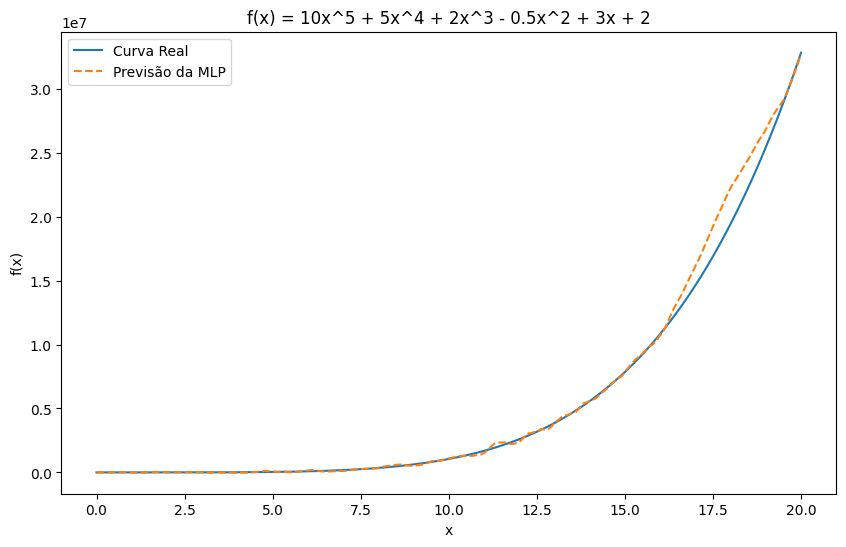

In [22]:
y_pred_poly = propaga(X_poly_norm)
y_pred_poly = y_pred_poly * y_poly_desvio + y_poly_media

plt.figure(figsize=(10, 6))
plt.plot(X_poly, y_poly, label='Curva Real')
plt.plot(X_poly, y_pred_poly, label='Previsão da MLP', linestyle='--')
plt.title('f(x) = 10x^5 + 5x^4 + 2x^3 - 0.5x^2 + 3x + 2')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.show()

# Exercicio 3

Considere um problema de classificação de padrões constituído de oito padrões. A distribuição dos padrões forma um círculo centrado na origem de raio unitário e contido no círculo um losango também centrado na origem e com lados iguais à raiz de 2. Os dados das classes C1, C2, C3, C4 correspondem aos quatro setores do losango e as outras quatro classes correspondem aos setores delimitados pelo círculo e os lados do losango. Após gerar aleatoriamente dados que venham formar estas distribuições de dados, selecione um conjunto de treinamento e um conjunto de validação. Treine duas redes perceptron (uma rede utilizando a regra delta convencional, e outra usando a regra delta com termo do momento), para classificar os padrões associados a cada uma das classes. Verifique o desempenho dos classificadores usando o conjunto de validação e calculando a matriz de confusão.


#### Funções Auxiliares

In [23]:
# Define uma função que calcula a precisão (accuracy) dadas as previsões e rótulos verdadeiros.
def accuracy(predictions, labels):
    # Compara o índice da categoria com maior probabilidade entre as previsões e os rótulos verdadeiros.
    correct_predictions = tf.equal(tf.argmax(predictions, 1), tf.argmax(labels, 1))
    
    # Calcula a média das previsões corretas, resultando na precisão.
    return tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

# Define uma função que verifica se um ponto (x,y) está dentro de um triângulo definido pelos vértices v1, v2 e v3.
def is_inside_triangle(x, y, v1, v2, v3):
    # Extração das coordenadas dos vértices do triângulo.
    x1, y1 = v1
    x2, y2 = v2
    x3, y3 = v3

    # Calcula a área do triângulo principal usando a fórmula de determinante.
    area_main = 0.5 * abs(x1*(y2-y3) + x2*(y3-y1) + x3*(y1-y2))
    
    # Calcula a área do triângulo formado pelo ponto (x,y) e os vértices v2 e v3.
    area1 = 0.5 * abs(x*(y2-y3) + x2*(y3-y) + x3*(y-y2))
    
    # Calcula a área do triângulo formado pelo ponto (x,y) e os vértices v1 e v3.
    area2 = 0.5 * abs(x1*(y-y3) + x*(y3-y1) + x3*(y1-y))
    
    # Calcula a área do triângulo formado pelo ponto (x,y) e os vértices v1 e v2.
    area3 = 0.5 * abs(x1*(y2-y) + x2*(y-y1) + x*(y1-y2))

    # Se a soma das três áreas menores for igual à área do triângulo principal, o ponto (x,y) está dentro do triângulo.
    return area_main == (area1 + area2 + area3)


#### 2. Geração de Dados

In [24]:
def generate_data(N):
    # Cria 'N' valores de theta igualmente espaçados entre 0 e 2 * pi.
    theta = np.linspace(0, 2 * np.pi, N)
    
    # Gera 'N' valores aleatórios entre 0 e 1.
    r = np.random.rand(N)
    
    # Calcula as coordenadas 'x' e 'y' para os pontos distribuídos em um círculo.
    x_circle = r * np.cos(theta)
    y_circle = r * np.sin(theta)

    # Listas para armazenar as coordenadas dos pontos e seus rótulos.
    X = []
    y = []

    # Itera sobre cada ponto.
    for x, y_c in zip(x_circle, y_circle):
        # Verifica se o ponto está no primeiro quadrante.
        if 0 <= x <= 1 and 0 <= y_c <= 1:
            # Verifica se o ponto está dentro do triângulo definido por (0,0), (1,0) e (0,1).
            if is_inside_triangle(x, y_c, (0,0), (1,0), (0,1)):
                y.append(0)  
            else:
                y.append(4)  
        # Verifica se o ponto está no segundo quadrante.
        elif -1 <= x < 0 and 0 <= y_c <= 1:
            # Verifica se o ponto está dentro do triângulo definido por (0,0), (-1,0) e (0,1).
            if is_inside_triangle(x, y_c, (0,0), (-1,0), (0,1)):
                y.append(1)  
            else:
                y.append(5)
        # Verifica se o ponto está no terceiro quadrante.
        elif -1 <= x < 0 and -1 <= y_c < 0:
            # Verifica se o ponto está dentro do triângulo definido por (0,0), (-1,0) e (0,-1).
            if is_inside_triangle(x, y_c, (0,0), (-1,0), (0,-1)):
                y.append(2)  
            else:
                y.append(6)
        # Verifica se o ponto está no quarto quadrante.
        elif 0 <= x <= 1 and -1 <= y_c < 0:
            # Verifica se o ponto está dentro do triângulo definido por (0,0), (1,0) e (0,-1).
            if is_inside_triangle(x, y_c, (0,0), (1,0), (0,-1)):
                y.append(3)  
            else:
                y.append(7)  

        # Adiciona as coordenadas do ponto à lista X.
        X.append([x, y_c])

    # Retorna as coordenadas e seus respectivos rótulos como arrays numpy.
    return np.array(X), y

# Gera os dados.
X, y = generate_data(10000)

#### 3. Divisão dos Dados

In [25]:
# Divide os dados (X e y) em conjuntos de treinamento e validação.
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Converte os conjuntos de treinamento e validação para tensores TensorFlow do tipo float32.
X_train, X_val = tf.convert_to_tensor(X_train, dtype=tf.float32), tf.convert_to_tensor(X_val, dtype=tf.float32)

# Converte os rótulos dos conjuntos de treinamento e validação para tensores TensorFlow do tipo int64.
y_train, y_val = tf.convert_to_tensor(y_train, dtype=tf.int64), tf.convert_to_tensor(y_val, dtype=tf.int64)


#### 4. Definição do Modelo

In [26]:
# Definição da classe Perceptron, que representa uma rede neural simples de duas camadas.
class Perceptron:
    
    # O método de inicialização da classe (__init__) define os pesos e vieses para as camadas oculta e de saída.
    def __init__(self, input_dim, hidden_dim, output_dim):
        # Os pesos são inicializados com valores aleatórios normalmente distribuídos com desvio padrão de 0.1.
        # Os vieses são inicializados com zeros.
        self.W1 = tf.Variable(tf.random.normal([input_dim, hidden_dim], stddev=0.1))
        self.b1 = tf.Variable(tf.zeros([hidden_dim]))
        
        # Inicializa os pesos (W2) e vieses (b2) da camada de saída, semelhante à camada oculta.
        self.W2 = tf.Variable(tf.random.normal([hidden_dim, output_dim], stddev=0.1))
        self.b2 = tf.Variable(tf.zeros([output_dim]))

    # O método __call__ define a operação da rede neural, permitindo que o objeto da classe seja chamado como uma função.
    def __call__(self, x):
        # Computa a saída da camada oculta usando a função de ativação ReLU.
        h = tf.nn.relu(tf.matmul(x, self.W1) + self.b1)
        
        # Computa a saída da camada final.
        y = tf.matmul(h, self.W2) + self.b2
        return y


#### 5. Funções de Treinamento

In [27]:
# Função que aplica o método do gradiente descendente para otimizar os parâmetros do modelo.
def train_delta(model, x, y, learning_rate=0.01):
    with tf.GradientTape() as tape:
        # Obtém as previsões do modelo a partir dos dados de entrada.
        logits = model(x)
        # Avalia o erro entre as previsões e os rótulos reais usando entropia cruzada.
        loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y))

        # Deriva a função de perda para obter os gradientes em relação aos parâmetros do modelo.
        gradients = tape.gradient(loss, [model.W1, model.b1, model.W2, model.b2])

        # Ajusta os parâmetros do modelo na direção que reduz o erro.
        model.W1.assign_sub(learning_rate * gradients[0])
        model.b1.assign_sub(learning_rate * gradients[1])
        model.W2.assign_sub(learning_rate * gradients[2])
        model.b2.assign_sub(learning_rate * gradients[3])

        # Devolve o valor atual da função de perda.
        return loss

# Função que otimiza o modelo usando gradiente descendente com o conceito de momentum.
def train_momentum(model, x, y, learning_rate=0.01, momentum=0.9, prev_gradients=None):
    with tf.GradientTape() as tape:
        # Obtém as previsões do modelo a partir dos dados de entrada.
        logits = model(x)
        # Avalia o erro entre as previsões e os rótulos reais usando entropia cruzada.
        loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y))

        # Deriva a função de perda para obter os gradientes em relação aos parâmetros do modelo.
        gradients = tape.gradient(loss, [model.W1, model.b1, model.W2, model.b2])

        # Se não tivermos gradientes anteriores, inicializamos com valores zero.
        if prev_gradients is None:
            prev_gradients = [tf.zeros_like(g) for g in gradients]

        # Combina o gradiente atual com os gradientes anteriores usando um fator de momentum.
        for i in range(4):
            gradients[i] = momentum * prev_gradients[i] + learning_rate * gradients[i]

        # Ajusta os parâmetros do modelo considerando o gradiente atualizado.
        model.W1.assign_sub(gradients[0])
        model.b1.assign_sub(gradients[1])
        model.W2.assign_sub(gradients[2])
        model.b2.assign_sub(gradients[3])
        
        # Devolve o valor atual da função de perda e os gradientes atualizados para uso em iterações futuras.
        return loss, gradients

#### 6. Função de Avaliação

In [28]:
# Função para calcular a acurácia do modelo em um conjunto de dados.
def compute_accuracy(model, x, y):
    # Realiza a propagação (forward pass) para obter as previsões do modelo.
    logits = model(x)
    
    # Determina a classe prevista para cada amostra pegando o índice do valor máximo ao longo do eixo 1.
    # Isso nos dá a classe com a maior probabilidade estimada.
    predicted_labels = tf.argmax(logits, axis=1)  # axis=1 para obter o índice da classe com maior probabilidade
    
    # Compara as classes previstas com as classes verdadeiras para identificar previsões corretas.
    correct_predictions = tf.equal(predicted_labels, y)
    
    # Calcula a acurácia média ao longo das previsões. Convertendo os valores booleanos para float32 (True para 1.0 e False para 0.0)
    # e depois calcula a média.
    accuracy_val = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
    
    # Retorna a acurácia convertida para valor numérico.
    return accuracy_val.numpy()


#### 7. Treinamento dos Modelos

In [29]:
# Treinando o modelo usando a regra delta convencional
# Inicializando o modelo Perceptron com 2 entradas, 50 neurônios na camada escondida e 8 saídas.
model_delta = Perceptron(2, 50, 8)

# Número total de épocas que o modelo será treinado.
EPOCHS = 10000

# Start timer for delta training
start_time_delta = time.time()

# Laço de treinamento para o modelo utilizando a regra delta convencional.
for epoch in range(EPOCHS):
    # Atualiza os pesos e vieses do modelo e calcula a perda.
    loss_delta = train_delta(model_delta, X_train, y_train)
    
    # A cada 1000 épocas, computa a acurácia nos conjuntos de treinamento e validação.
    if epoch % 1000 == 0:
        acc_train = compute_accuracy(model_delta, X_train, y_train)
        acc_val = compute_accuracy(model_delta, X_val, y_val)
        print(f"Epoch {epoch}/{EPOCHS}, Delta Loss: {loss_delta:.4f}, Train Acc: {acc_train:.4f}, Val Acc: {acc_val:.4f}")

# Stop timer for delta training
end_time_delta = time.time()
duration_delta = end_time_delta - start_time_delta
print(f"\nTempo total de execução (Delta): {duration_delta:.2f} segundos.\n")

# Treinando o modelo usando a regra delta com momento (momentum)
# Inicializando o modelo Perceptron com 2 entradas, 50 neurônios na camada escondida e 8 saídas.
model_momentum = Perceptron(2, 50, 8)

# Esta variável armazenará os gradientes anteriores para uso na atualização de momento.
prev_gradients = None

# Start timer for momentum training
start_time_momentum = time.time()

# Laço de treinamento para o modelo utilizando a regra delta com momento.
for epoch in range(EPOCHS):
    # Atualiza os pesos e vieses do modelo usando momentum, e calcula a perda.
    loss_momentum, prev_gradients = train_momentum(model_momentum, X_train, y_train, prev_gradients=prev_gradients)
    
    # A cada 1000 épocas, computa a acurácia nos conjuntos de treinamento e validação.
    if epoch % 1000 == 0:
        acc_train = compute_accuracy(model_momentum, X_train, y_train)
        acc_val = compute_accuracy(model_momentum, X_val, y_val)
        print(f"Epoch {epoch}/{EPOCHS}, Momentum Loss: {loss_momentum:.4f}, Train Acc: {acc_train:.4f}, Val Acc: {acc_val:.4f}")

# Stop timer for momentum training
end_time_momentum = time.time()
duration_momentum = end_time_momentum - start_time_momentum
print(f"\nTempo total de execução (Momentum): {duration_momentum:.2f} segundos.")


Epoch 0/10000, Delta Loss: 2.0756, Train Acc: 0.3068, Val Acc: 0.3185
Epoch 1000/10000, Delta Loss: 1.7302, Train Acc: 0.6224, Val Acc: 0.6210
Epoch 2000/10000, Delta Loss: 1.4016, Train Acc: 0.7161, Val Acc: 0.7155
Epoch 3000/10000, Delta Loss: 1.1431, Train Acc: 0.7368, Val Acc: 0.7390
Epoch 4000/10000, Delta Loss: 0.9677, Train Acc: 0.7483, Val Acc: 0.7510
Epoch 5000/10000, Delta Loss: 0.8425, Train Acc: 0.7540, Val Acc: 0.7575
Epoch 6000/10000, Delta Loss: 0.7500, Train Acc: 0.7930, Val Acc: 0.7995
Epoch 7000/10000, Delta Loss: 0.6807, Train Acc: 0.8535, Val Acc: 0.8600
Epoch 8000/10000, Delta Loss: 0.6279, Train Acc: 0.8915, Val Acc: 0.8985
Epoch 9000/10000, Delta Loss: 0.5867, Train Acc: 0.9173, Val Acc: 0.9245

Tempo total de execução (Delta): 19.22 segundos.

Epoch 0/10000, Momentum Loss: 2.0756, Train Acc: 0.3068, Val Acc: 0.3185
Epoch 1000/10000, Momentum Loss: 0.5594, Train Acc: 0.9274, Val Acc: 0.9410
Epoch 2000/10000, Momentum Loss: 0.4091, Train Acc: 0.9623, Val Acc: 0.96

#### 8. Avaliação dos Modelos

In [30]:
# Prevendo as classes para o conjunto de validação usando o modelo treinado com a regra delta convencional.
# 'tf.argmax' é utilizado para obter o índice da classe com maior probabilidade.
y_pred_delta = tf.argmax(model_delta(X_val), axis=1).numpy()

# Prevendo as classes para o conjunto de validação usando o modelo treinado com a regra delta com momento.
y_pred_momentum = tf.argmax(model_momentum(X_val), axis=1).numpy()

# -  classes reais
# p
# r
# e
# v
# i
# s
# a
# o

# Imprimindo a matriz de confusão para as previsões do modelo treinado com a regra delta convencional.
print("Matriz de Confusão - Delta Convencional:")
print(confusion_matrix(y_val, y_pred_delta))

# Imprimindo a matriz de confusão para as previsões do modelo treinado com a regra delta com momento.
print("\nMatriz de Confusão - Delta com Momento:")
print(confusion_matrix(y_val, y_pred_momentum))

Matriz de Confusão - Delta Convencional:
[[381   2   1   4   4   0   0   0]
 [  1 385   7   0   0   0   0   0]
 [  0   0 393   0   0   0   0   0]
 [  0   0   8 373   0   0   0   0]
 [ 17   0   0   0 103   0   0   0]
 [  0  23   0   0   0  84   0   0]
 [  0   0  32   0   0   0  67   0]
 [  0   0   0  23   0   0   0  92]]

Matriz de Confusão - Delta com Momento:
[[375   3   0   9   5   0   0   0]
 [  0 390   2   0   0   1   0   0]
 [  0   1 391   1   0   0   0   0]
 [  2   0   1 370   0   0   0   8]
 [  9   0   0   0 111   0   0   0]
 [  0   9   0   0   0  98   0   0]
 [  0   0   9   0   0   0  90   0]
 [  0   0   0   9   0   0   0 106]]


#### 9. Visualização dos resultados

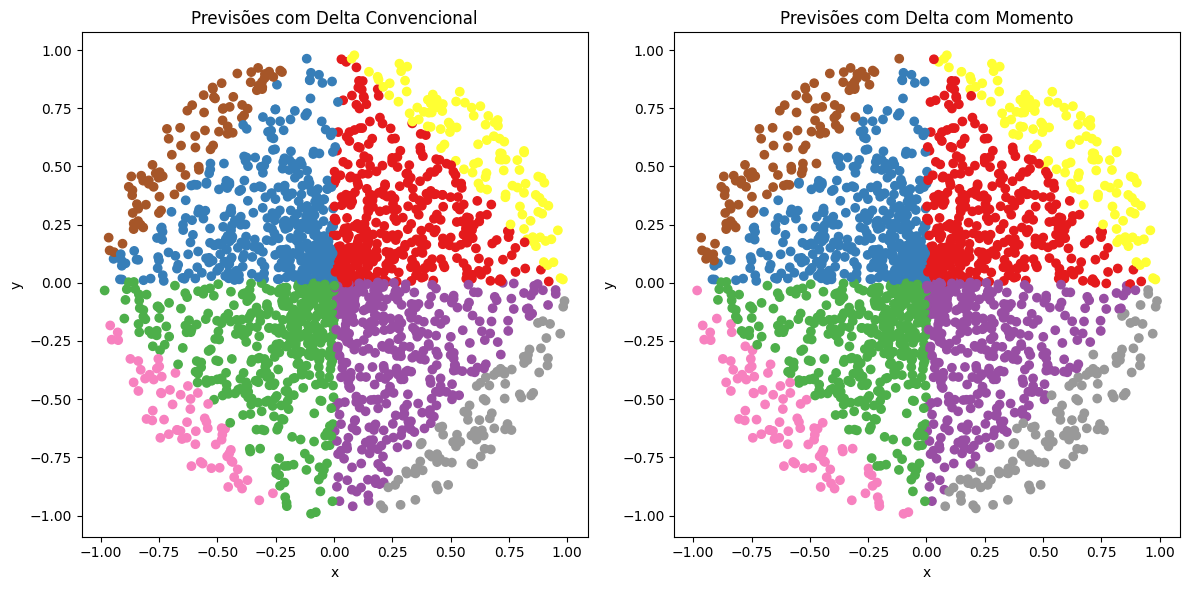

In [31]:
# Gráfico para Delta Convencional
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(X_val[:, 0], X_val[:, 1], c=y_pred_delta, cmap='Set1')
plt.title('Previsões com Delta Convencional')
plt.xlabel('x')
plt.ylabel('y')

# Gráfico para Delta com Momento
plt.subplot(1, 2, 2)
plt.scatter(X_val[:, 0], X_val[:, 1], c=y_pred_momentum, cmap='Set1')
plt.title('Previsões com Delta com Momento')
plt.xlabel('x')
plt.ylabel('y')

plt.tight_layout()
plt.show()

# Exercicio 4

Utilize a rede neural perceptron de múltiplas camadas para fazer a predição de um passo, até predição de três passos, da série temporal: x(n) = sen2(n) + cos(n+cos(n)). Avalie o desempenho mostrando para cada caso os erros de predição.

Dica: Para auxiliar na resolução desse problema você pode usar K entradas (por exemplo, K=10), que correspondem a K passos anteriores a n: x(n-1), x(n-2),..., x(n-K), e deve fazer a predição dos valores x(n+1), x(n+2) e x(n+3).

#### 1. Geração da Série Temporal

In [32]:
N = 100000
n = np.arange(0, N, 0.1)
x = np.sin(n**2) + np.cos(n + np.cos(n))

K = 100
X = []
Y = []

for i in range(K, N-3):
    X.append(x[i-K:i])
    Y.append([x[i], x[i+1], x[i+2]])

X = np.array(X).astype(np.float32)
Y = np.array(Y).astype(np.float32)

# Dividir os dados em treinamento e teste
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:] 

start_test = 0
end_test = 40
n_test = np.arange(start_test, end_test, 0.1)

#### 2. Criando e treinando o modelo

In [33]:
# Construir o modelo
class MLP(tf.Module):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.W1 = tf.Variable(tf.random.normal([K, 50]), name='W1')
        self.b1 = tf.Variable(tf.zeros([50]), name='b1')
        self.W2 = tf.Variable(tf.random.normal([50, 50]), name='W2')
        self.b2 = tf.Variable(tf.zeros([50]), name='b2')
        self.W3 = tf.Variable(tf.random.normal([50, 3]), name='W3')
        self.b3 = tf.Variable(tf.zeros([3]), name='b3')
        
    def __call__(self, x):
        layer1 = tf.nn.relu(tf.add(tf.matmul(x, self.W1), self.b1))
        layer2 = tf.nn.relu(tf.add(tf.matmul(layer1, self.W2), self.b2))
        return tf.add(tf.matmul(layer2, self.W3), self.b3)

# Hiperparâmetros
learning_rate = 0.01
epochs = 1000
batch_size = 2048
n_batches = int(train_size/batch_size)

model = MLP()
loss_fn = tf.losses.MeanSquaredError()
optimizer = tf.optimizers.legacy.Adam(learning_rate)

# Loop de treinamento
for epoch in range(epochs):
    for batch in range(n_batches):
        batch_start = batch * batch_size
        batch_end = (batch+1) * batch_size
        batch_x = X_train[batch_start:batch_end]
        batch_y = Y_train[batch_start:batch_end]

        with tf.GradientTape() as tape:
            predictions = model(batch_x)
            loss = loss_fn(batch_y, predictions)

        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
    # Imprimir o erro a cada 100 épocas
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.numpy()}")

Y_pred = model(X_test)


Epoch 0, Loss: 1999.2569580078125
Epoch 100, Loss: 1.5471704006195068
Epoch 200, Loss: 0.5686477422714233
Epoch 300, Loss: 0.30854979157447815
Epoch 400, Loss: 0.0373617447912693
Epoch 500, Loss: 0.009057888761162758
Epoch 600, Loss: 0.007519497536122799
Epoch 700, Loss: 0.005742528010159731
Epoch 800, Loss: 0.0031817378476262093
Epoch 900, Loss: 0.0034202001988887787


#### 3. Calculando os MSE

In [34]:
error_1_step = mean_squared_error(Y_test[:, 0], Y_pred[:, 0])
error_2_steps = mean_squared_error(Y_test[:, 1], Y_pred[:, 1])
error_3_steps = mean_squared_error(Y_test[:, 2], Y_pred[:, 2])

print(f"Erro de predição de 1 passo: {error_1_step}")
print(f"Erro de predição de 2 passos: {error_2_steps}")
print(f"Erro de predição de 3 passos: {error_3_steps}")


Erro de predição de 1 passo: 0.0025944083463400602
Erro de predição de 2 passos: 0.0048666056245565414
Erro de predição de 3 passos: 0.002752327360212803


#### 4. Graficos

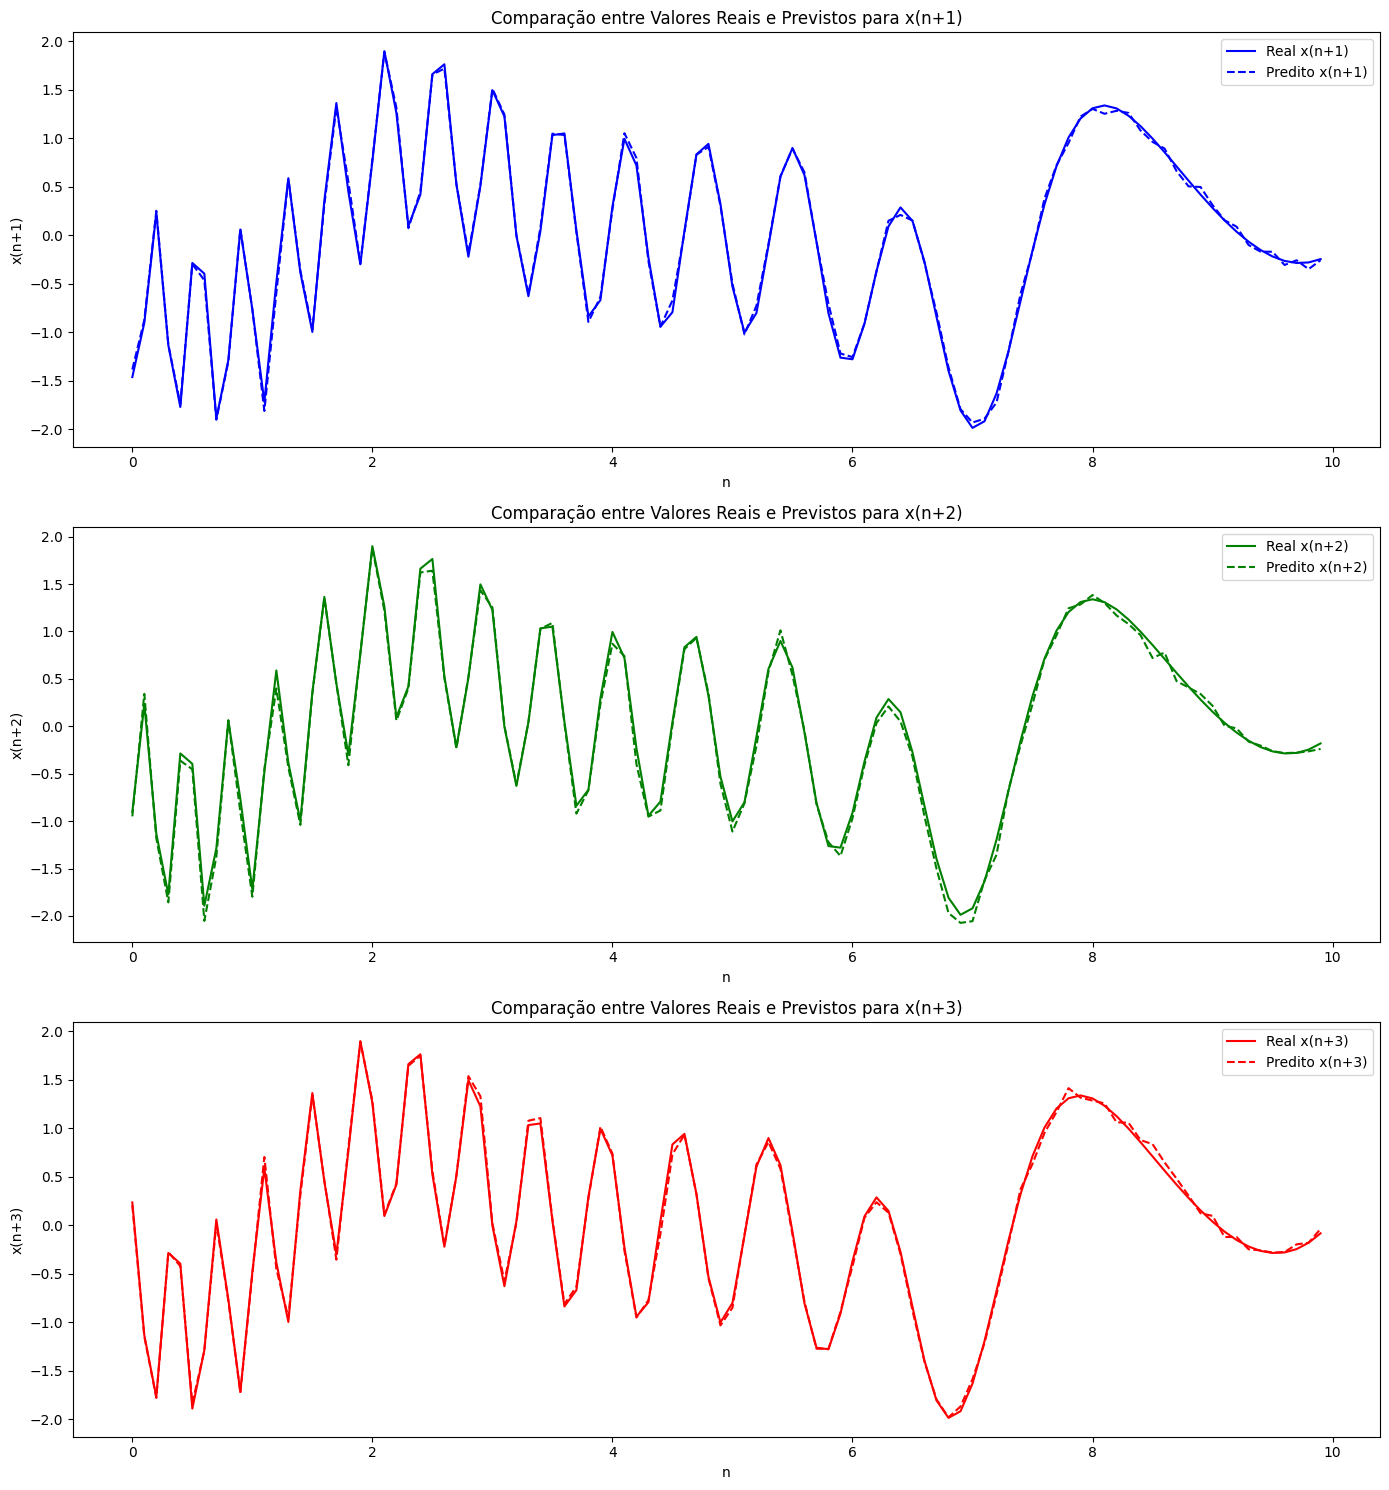

In [35]:
intervalo = 100

# Selecione os primeiros `intervalo` pontos
n_test_intervalo = n_test[:intervalo]
Y_test_intervalo = Y_test[:intervalo]
Y_pred_intervalo = Y_pred[:intervalo]

# Criando os gráficos
fig, axs = plt.subplots(3, 1, figsize=(14, 15))

# Gráfico para x(n+1)
axs[0].plot(n_test_intervalo, Y_test_intervalo[:, 0], label="Real x(n+1)", color="blue")
axs[0].plot(n_test_intervalo, Y_pred_intervalo[:, 0], label="Predito x(n+1)", linestyle='dashed', color="blue")
axs[0].set_title("Comparação entre Valores Reais e Previstos para x(n+1)")
axs[0].set_xlabel("n")
axs[0].set_ylabel("x(n+1)")
axs[0].legend()

# Gráfico para x(n+2)
axs[1].plot(n_test_intervalo, Y_test_intervalo[:, 1], label="Real x(n+2)", color="green")
axs[1].plot(n_test_intervalo, Y_pred_intervalo[:, 1], label="Predito x(n+2)", linestyle='dashed', color="green")
axs[1].set_title("Comparação entre Valores Reais e Previstos para x(n+2)")
axs[1].set_xlabel("n")
axs[1].set_ylabel("x(n+2)")
axs[1].legend()

# Gráfico para x(n+3)
axs[2].plot(n_test_intervalo, Y_test_intervalo[:, 2], label="Real x(n+3)", color="red")
axs[2].plot(n_test_intervalo, Y_pred_intervalo[:, 2], label="Predito x(n+3)", linestyle='dashed', color="red")
axs[2].set_title("Comparação entre Valores Reais e Previstos para x(n+3)")
axs[2].set_xlabel("n")
axs[2].set_ylabel("x(n+3)")
axs[2].legend()

plt.tight_layout()
plt.show()
